## 머신러닝의 입력과 출력

### ETL 문자 데이터베이스 사용하기
- [데이터베이스](http://etlcdb.db.aist.go.jp/) - 사용 목적, 이메일 주소 입력 - 다운로드 링크와 비밀번호를 통해 데이터 다운로드

### 데이터베이스를 이미지로 변환하기

In [1]:
# ETL1 파일 읽어들이기
import struct
from PIL import Image, ImageEnhance
import glob, os

# 출력 디렉터리
outdir = '../datasets/png-etl1/'
if not os.path.exists(outdir): os.mkdir(outdir)

In [4]:
# ETL1 디렉터리 아래의 파일 처리하기
files = glob.glob('../datasets/ETL1/*')
for fname in files:
    if fname == r'../datasets/ETL1\ETL1INFO': continue # 정보 파일 무시하기
    print(fname)
    
    # ETL1 데이터 파일 열기
    f = open(fname, 'rb')
    f.seek(0)
    
    while True:
        # 메타데이터와 이미지 데이터 조합을 하나씩 읽어들이기
        s = f.read(2052)
        if not s:break
        # 바이너리 데이터이므로 python에서 사용할 수 있는 형태로 읽어들이기
        r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
        code_ascii = r[1]
        code_jis = r[3]
        
        # 이미지 데이터로 추출하기
        iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
        iP = iF.convert('L')
        
        # 이미지를 선명하게 해서 저장하기
        dir = outdir + '/' + str(code_jis)
        if not os.path.exists(dir): os.mkdir(dir)
        fn = '{0:02x}-{1:02x}{2:04x}.png'.format(code_jis, r[0], r[2])
        fullpath = dir + '/' + fn
        if os.path.exists(fullpath): continue
            
        enhancer = ImageEnhance.Brightness(iP)
        iE = enhancer.enhance(16)
        iE.save(fullpath, 'PNG')
print('ok')

../datasets/ETL1\ETL1C_01
../datasets/ETL1\ETL1C_02
../datasets/ETL1\ETL1C_03
../datasets/ETL1\ETL1C_04
../datasets/ETL1\ETL1C_05
../datasets/ETL1\ETL1C_06
../datasets/ETL1\ETL1C_07
../datasets/ETL1\ETL1C_08
../datasets/ETL1\ETL1C_09
../datasets/ETL1\ETL1C_10
../datasets/ETL1\ETL1C_11
../datasets/ETL1\ETL1C_12
../datasets/ETL1\ETL1C_13
ok


## 이미지 학습시키기 - 이미지 리사이즈

dir = ../datasets/png-etl1/177
dir = ../datasets/png-etl1/178
dir = ../datasets/png-etl1/179
dir = ../datasets/png-etl1/180
dir = ../datasets/png-etl1/181
dir = ../datasets/png-etl1/182
dir = ../datasets/png-etl1/183
dir = ../datasets/png-etl1/184
dir = ../datasets/png-etl1/185
dir = ../datasets/png-etl1/186
dir = ../datasets/png-etl1/187
dir = ../datasets/png-etl1/188
dir = ../datasets/png-etl1/189
dir = ../datasets/png-etl1/190
dir = ../datasets/png-etl1/191
dir = ../datasets/png-etl1/192
dir = ../datasets/png-etl1/193
dir = ../datasets/png-etl1/194
dir = ../datasets/png-etl1/195
dir = ../datasets/png-etl1/196
dir = ../datasets/png-etl1/197
dir = ../datasets/png-etl1/198
dir = ../datasets/png-etl1/199
dir = ../datasets/png-etl1/200
dir = ../datasets/png-etl1/201
dir = ../datasets/png-etl1/202
dir = ../datasets/png-etl1/203
dir = ../datasets/png-etl1/204
dir = ../datasets/png-etl1/205
dir = ../datasets/png-etl1/206
dir = ../datasets/png-etl1/207
dir = ../datasets/png-etl1/208
dir = ..

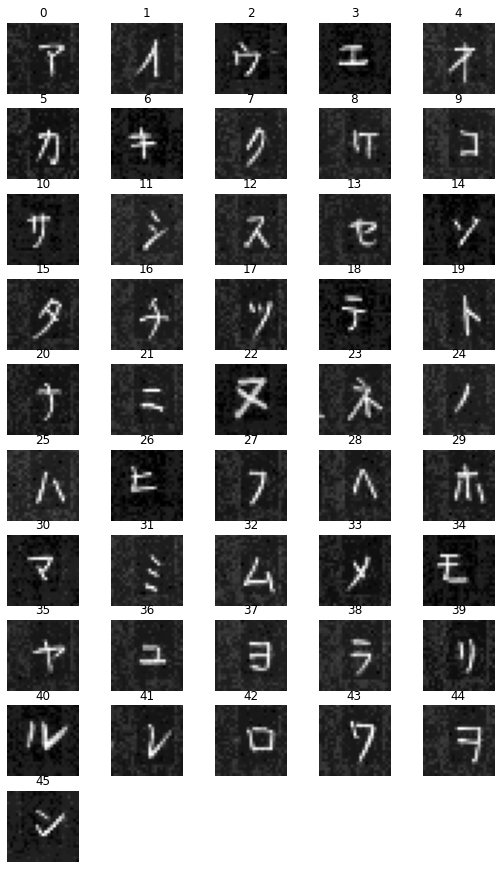

ok


In [5]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

# 저장 경로와 이미지 크기 지정
out_dir = '../datasets/png-etl1' # 이미지 데이터가 있는 디렉터리
im_size = 25 # 이미지 크기
save_file = out_dir + '/katakana.pickle' # 저장 경로
plt.figure(figsize=(9, 17))

# 이미지 추출
kanadir = list(range(177, 220+1))
kanadir.append(166) # ヲ
kanadir.append(221) # ン
result = []
for i, code in enumerate(kanadir):
    img_dir = out_dir + "/" + str(code)
    fs = glob.glob(img_dir + '/*')
    print('dir =', img_dir)
    
    # 이미지를 읽어 들이고 그레이 스케일로 변환, 크기 변경
    for j, f in enumerate(fs):
        img = cv2.imread(f)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img_gray, (im_size, im_size))
        result.append([i, img])
        
        # 이미지 출력
        if j == 3:
            plt.subplot(11, 5, i+1)
            plt.axis('off')
            plt.title(str(i))
            plt.imshow(img, cmap='gray')
            
# 레이블 데이터와 이미지 데이터 저장
pickle.dump(result, open(save_file, 'wb'))
plt.show()
print('ok')

### 데이터 학습하기

In [7]:
import numpy as np
import cv2, pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras

# 데이터 파일과 이미지 크기 지정
data_file = '../datasets/png-etl1/katakana.pickle'
im_size = 25
in_size = im_size * im_size
out_size = 46 # 가타카나 수

# 이미지 데이터 불러오기
data = pickle.load(open(data_file, 'rb'))

# 이미지 데이터를 0과 1 사이의 값으로 정규화
y = []
x = []
for d in data:
    num, img = d
    img = img.reshape(-1).astype('float') / 255
    y.append(keras.utils.to_categorical(num, out_size))
    x.append(img)
x = np.array(x)
y = np.array(y)

# 학습, 테스트 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [9]:
# 모델 구조 정의
Dense = keras.layers.Dense
model = keras.models.Sequential()
model.add(Dense(512, activation='relu', input_shape = (in_size, )))
model.add(Dense(out_size, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               320512    
_________________________________________________________________
dense_1 (Dense)              (None, 46)                23598     
Total params: 344,110
Trainable params: 344,110
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy',
             optimizer = 'adam', metrics=['accuracy'])

In [12]:
# 학습
hist = model.fit(x_train, y_train, batch_size=20,
                epochs=50, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
2766/2766 [==============================] - 8s 2ms/step - loss: 2.2306 - accuracy: 0.4347 - val_loss: 1.3301 - val_accuracy: 0.6654
Epoch 2/50
2766/2766 [==============================] - 6s 2ms/step - loss: 1.0104 - accuracy: 0.7378 - val_loss: 0.8370 - val_accuracy: 0.7823
Epoch 3/50
2766/2766 [==============================] - 6s 2ms/step - loss: 0.6630 - accuracy: 0.8246 - val_loss: 0.6597 - val_accuracy: 0.8236
Epoch 4/50
2766/2766 [==============================] - 6s 2ms/step - loss: 0.5070 - accuracy: 0.8646 - val_loss: 0.5696 - val_accuracy: 0.8455
Epoch 5/50
2766/2766 [==============================] - 6s 2ms/step - loss: 0.4134 - accuracy: 0.8884 - val_loss: 0.5215 - val_accuracy: 0.8604
Epoch 6/50
2766/2766 [==============================] - 6s 2ms/step - loss: 0.3520 - accuracy: 0.9047 - val_loss: 0.4659 - val_accuracy: 0.8737
Epoch 7/50
2766/2766 [==============================] - 6s 2ms/step - loss: 0.3014 - accuracy: 0.9192 - val_loss: 0.4421 - val_accuracy:

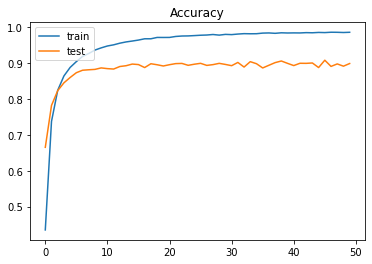

In [13]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

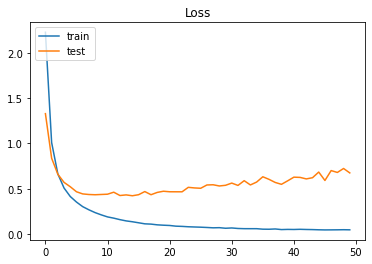

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN으로 학습하기

In [21]:
import numpy as np
import cv2, pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# 데이터 파일과 이미지 크기 지정
data_file = '../datasets/png-etl1/katakana.pickle'
im_size = 25
out_size = 46
im_color = 1 # 이미지 색공간
in_shape = (im_size, im_size, im_color)
data = pickle.load(open(data_file, 'rb'))

# 이미지 데이터를 0과 1 사이의 값으로 정규화
y = []
x = []
for d in data:
    num, img = d
    img = img.astype('float').reshape(im_size, im_size, im_color) / 255
    y.append(keras.utils.to_categorical(num, out_size))
    x.append(img)
x = np.array(x)
y = np.array(y)

# 학습, 테스트 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [22]:
# 모델 정의
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = in_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(out_size, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 23, 23, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               819328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [24]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(), metrics=['accuracy'])

In [25]:
# 학습, 평가
hist = model.fit(x_train, y_train, batch_size=128,
                epochs=12, verbose=1, validation_data=(x_test, y_test))

Epoch 1/12
433/433 [==============================] - 11s 9ms/step - loss: 2.0491 - accuracy: 0.4384 - val_loss: 0.7441 - val_accuracy: 0.8085
Epoch 2/12
433/433 [==============================] - 4s 8ms/step - loss: 0.9038 - accuracy: 0.7274 - val_loss: 0.4319 - val_accuracy: 0.8817
Epoch 3/12
433/433 [==============================] - 4s 8ms/step - loss: 0.6528 - accuracy: 0.8054 - val_loss: 0.3351 - val_accuracy: 0.9091
Epoch 4/12
433/433 [==============================] - 4s 8ms/step - loss: 0.5420 - accuracy: 0.8411 - val_loss: 0.2862 - val_accuracy: 0.9224
Epoch 5/12
433/433 [==============================] - 4s 8ms/step - loss: 0.4689 - accuracy: 0.8642 - val_loss: 0.3040 - val_accuracy: 0.9171
Epoch 6/12
433/433 [==============================] - 4s 8ms/step - loss: 0.4137 - accuracy: 0.8813 - val_loss: 0.2382 - val_accuracy: 0.9421
Epoch 7/12
433/433 [==============================] - 4s 8ms/step - loss: 0.3737 - accuracy: 0.8938 - val_loss: 0.1921 - val_accuracy: 0.9510
Epoch

In [27]:
# 모델 평가하기
score = model.evaluate(x_test, y_test, verbose=1)
print('정답률 :', score[1], 'loss :', score[0])

433/433 [==============================] - 1s 2ms/step - loss: 0.1517 - accuracy: 0.9608
정답률 : 0.9608041644096375 loss : 0.15165452659130096


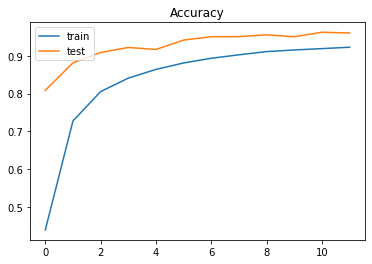

In [28]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

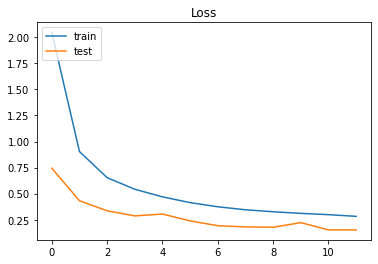

In [29]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

약 90%에서 96%로 향상

### 참고
- 데이터 수, 너비, 높이, 색

In [30]:
x_train.shape

(55309, 25, 25, 1)